In [26]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
import plotnine as p9
from mizani.transforms import modulus_trans 
from sklearn.feature_selection import SelectFromModel

## Part 0: Data Setup

In [2]:
hit = pd.read_csv(r"C:\Users\ldcal\OneDrive\Desktop\Cal Poly Courses\Fall\GSB-S544\Coding Work\Pyython_Work\LAB 6\Hitters.csv")

hit_na = hit.dropna()
hit_clean = pd.get_dummies(hit_na)

## Part 1: Different Model Specs

### A. Regression without Regularization 

#### 1. Pipeline that includes all columns as predictors and does OLS

In [3]:
ct = ColumnTransformer(
    [("num", StandardScaler(), make_column_selector(dtype_include=np.number)),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output = False)
    , make_column_selector(dtype_exclude=np.number)),  
    ], 
    remainder = "drop" 

).set_output(transform = "pandas" ,)


lr_pipeline1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

#### 2. Fit pipeline to full dataset and interpret

In [4]:
X_A = hit_clean.drop("Salary", axis = 1)
y_A = hit_clean["Salary"]

X_A_train, X_A_test, y_A_train, y__A_test = train_test_split(X_A, y_A)

In [5]:
fitted_lr1_A = lr_pipeline1.fit(X_A_train, y_A_train)

fit_lr1_A_feat= fitted_lr1_A["linear_regression"].feature_names_in_
fit_lr1_A_coefs = fitted_lr1_A["linear_regression"].coef_

lr1_A_coefs = pd.DataFrame({"feature": fit_lr1_A_feat, "coef": fit_lr1_A_coefs})
lr1_A_coefs

,feature,coef
0,num__AtBat,-226.909353
1,num__Hits,286.429362
2,num__HmRun,76.310830
3,num__Runs,-67.928252
4,num__RBI,-75.493683
5,num__Walks,129.671846
6,num__Years,-11.032786
7,num__CAtBat,-278.655694
8,num__CHits,-236.429436
9,num__CHmRun,-144.490701


Some of the most important coefficients appear to be the number of hits during a players career which makese sense where the more a player is hitting a baseball, the higher their salary is likely to be. Also an intresting observation is the more a player is at bat the less they get paid, which doesn't logically make sense as players who are on offense are more likely to win games. career runs also had a very positive impact as runs are very important to the game and so can be highly valued. 

#### 3. Cross validation to estiamte the MSE if we used this pipeline to predict 1989 salaries 

In [6]:
(-(cross_val_score(lr_pipeline1, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()

np.float64(342.1395913172416)

### B. Ridge Regression

#### 1. Create pipeline to preform ordinary ridge regression

In [7]:
R_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge", Ridge(alpha = 200))]
).set_output(transform="pandas")

#### 2. Use Cross Val to tune the lambda hyperparameter 

In [8]:
alphas_tune = {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10,200]}

grid_search1 = GridSearchCV(estimator = R_pipeline,
                           param_grid = alphas_tune,
                           cv=5, 
                           scoring='r2')

In [9]:
fitted_grid1 = grid_search1.fit(X_A, y_A)

In [10]:
ridge_tune_1 = pd.DataFrame(data = {"alphas":fitted_grid1.cv_results_["params"],
                                    "scores": fitted_grid1.cv_results_['mean_test_score']})

print("the lambda with the highest score for ridge regression was 200 based on the alphas we tested")
ridge_tune_1

the lambda with the highest score for ridge regression was 200 based on the alphas we tested


,alphas,scores
0,{'ridge__alpha': 0.001},0.343556
1,{'ridge__alpha': 0.01},0.344080
2,{'ridge__alpha': 0.1},0.347631
3,{'ridge__alpha': 1},0.355375
4,{'ridge__alpha': 10},0.366328
5,{'ridge__alpha': 200},0.387161


#### 3. Fit the pipeline with choosen lambda on full dataset and interpret 

In [11]:
fitted_R1 = R_pipeline.fit(X_A_train, y_A_train)

fit_R1_feat= fitted_R1["ridge"].feature_names_in_
fit_R1_coefs = fitted_R1["ridge"].coef_

R1_A_coefs = pd.DataFrame({"feature": fit_R1_feat, "coef": fit_R1_coefs})
R1_A_coefs

,feature,coef
0,num__AtBat,16.162456
1,num__Hits,27.367930
2,num__HmRun,9.977364
3,num__Runs,21.928456
4,num__RBI,21.037637
5,num__Walks,27.627225
6,num__Years,9.904808
7,num__CAtBat,26.099737
8,num__CHits,32.977701
9,num__CHmRun,30.653374


In our ridge regression put outs was one of the most impactfull coefficients with the salary increase being the most for every category, possibly showing the models use of deffensive stats toward salary values. One thing to note on these coefficents is that they are not as high as the previous model meaning that we etheir have a high y intercepts or some misstrained models. 

#### 4. MSE Expected if used to predict 1989 salaries 

In [221]:
R_og_MSE = (-(cross_val_score(R_pipeline, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()

### C. Lasso Regression

#### 1. Create a Pipeline for all columns and performs Ordinary Lasso Regression

In [13]:
L_pipeline = Pipeline(
  [("preprocessing", ct),
  ("Lasso", Lasso(alpha = 20))]
).set_output(transform="pandas")

#### 2. Cross val to find the best lambda 

In [14]:
alphas_tune2 = {"Lasso__alpha": [0.001, 0.01, 0.1, 1, 10,20]}

grid_search2 = GridSearchCV(estimator = L_pipeline,
                           param_grid = alphas_tune2,
                           cv=5, 
                           scoring='r2')

In [15]:
fitted_grid2 = grid_search2.fit(X_A, y_A)

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.983e+06, tolerance: 3.606e+03
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+07, tolerance: 4.137e+03
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

In [16]:
lasso_tune_2 = pd.DataFrame(data = {"alphas":fitted_grid2.cv_results_["params"],
                                    "scores": fitted_grid2.cv_results_['mean_test_score']})


print("the lambda paramater that worked best for this model was 20")
lasso_tune_2

the lambda paramater that worked best for this model was 20


,alphas,scores
0,{'Lasso__alpha': 0.001},0.344223
1,{'Lasso__alpha': 0.01},0.344394
2,{'Lasso__alpha': 0.1},0.346041
3,{'Lasso__alpha': 1},0.354238
4,{'Lasso__alpha': 10},0.369523
5,{'Lasso__alpha': 20},0.377168


#### 3. Fit Pipeline with choosen lambda and interpret coefficeints 

In [17]:
pd.set_option('display.float_format', '{:.6f}'.format)

In [18]:
fitted_L1 = L_pipeline.fit(X_A_train, y_A_train)

fit_L1_feat= fitted_L1["Lasso"].feature_names_in_
fit_L1_coefs = fitted_L1["Lasso"].coef_

L1_A_coefs = pd.DataFrame({"feature": fit_L1_feat, "coef": fit_L1_coefs})
L1_A_coefs

,feature,coef
0,num__AtBat,0.000000
1,num__Hits,74.591460
2,num__HmRun,0.000000
3,num__Runs,0.000000
4,num__RBI,0.000000
5,num__Walks,37.384076
6,num__Years,-0.000000
7,num__CAtBat,0.000000
8,num__CHits,0.000000
9,num__CHmRun,0.000000


This Lasso regression had a lot of zero values indicating that their the regression did not do a good job at fitting to our data. Some of the coefficents that were the most supprising were the runs column which played a factor in the previous model but not in this one. it is also worth noticing that the categorical variables all had very week effects on salary indicating a faulty model for this data. 

#### 4. Reporting the MSE for the pipeline predicting salaries in 1989

In [217]:
L_og_MSE = (-(cross_val_score(L_pipeline, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()

### D. Elastic Net

#### 1. Create a Pipeline For all Columns that perfroms Elastic Net Regression

In [20]:
EN_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet(alpha = 1, l1_ratio = 0.1))]
).set_output(transform="pandas")

#### 2. Cross Val Tun for both parameters 

In [21]:
param_grid3 = {'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 2],
              "elastic_net__l1_ratio": [0.001, 0.01, 0.1, 1]}


grid_search3 = GridSearchCV(estimator = EN_pipeline,
                           param_grid = param_grid3,
                           cv=5, 
                           scoring='r2')

In [22]:
fitted_grid3 = grid_search3.fit(X_A, y_A)

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+07, tolerance: 4.708e+03
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.227e+06, tolerance: 3.606e+03
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+07, tolerance: 4.137e+03
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

In [23]:
lasso_tune_3 = pd.DataFrame(data = {"alphas":fitted_grid3.cv_results_["params"],
                                    "scores": fitted_grid3.cv_results_['mean_test_score']})

print(lasso_tune_3.loc[lasso_tune_3["scores"].idxmax(), "alphas"])
lasso_tune_3.loc[lasso_tune_3["scores"].idxmax(), "scores"]

{'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.1}


np.float64(0.3872138542865288)

#### 3. Fit the Pipeline and Interprect coefficients 

In [24]:
fitted_EN1 = EN_pipeline.fit(X_A_train, y_A_train)

fit_EN1_feat= fitted_EN1["elastic_net"].feature_names_in_
fit_EN1_coefs = fitted_EN1["elastic_net"].coef_

EN1_A_coefs = pd.DataFrame({"feature": fit_EN1_feat, "coef": fit_EN1_coefs})
EN1_A_coefs

,feature,coef
0,num__AtBat,15.604434
1,num__Hits,28.277029
2,num__HmRun,9.326023
3,num__Runs,22.274608
4,num__RBI,21.026695
5,num__Walks,28.360018
6,num__Years,8.875091
7,num__CAtBat,26.326122
8,num__CHits,33.997130
9,num__CHmRun,31.584649


This model performed very simmilar to the Ridge regression model with import ceofficients being put outs and Cruns and had slightly higher salary rises per coefficent indicating that this model may fit the salaries better than the other models. 

#### 4. Reporting MSE using our pipeline for salaries in 1989

In [220]:
EN_og_MSE = (-(cross_val_score(EN_pipeline, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()

## Part 2: Variable Selection 

### A. Deciding on Top Variables to use 

In [68]:
top5_lr = (lr1_A_coefs
        .assign(abs_coef=lambda d: d["coef"].abs())
        .assign(model = "Linear Regression")
        .nlargest(5, "abs_coef"))

top5_R = (R1_A_coefs
        .assign(abs_coef=lambda d: d["coef"].abs())
        .assign(model = "Ridge")
        .nlargest(5, "abs_coef"))  

top6_L = (L1_A_coefs
        .assign(abs_coef=lambda d: d["coef"].abs())
        .assign(model = "Lasso")
        .nlargest(6, "abs_coef"))
  

top5_EN = (EN1_A_coefs
        .assign(abs_coef=lambda d: d["coef"].abs())
        .assign(model = "Elastic Net")
        .nlargest(5, "abs_coef"))

top5_num = pd.concat([top5_lr, top5_R, top6_L, top5_EN], ignore_index=True)

top5_num.groupby("feature")["abs_coef"].mean().nlargest(1)

feature
num__CAtBat   278.655694
Name: abs_coef, dtype: float64

Based on the 4 models average coefficent values we can determine the top numeric value to be CAtBat, indicating this as the most important value for all of the models 

In [69]:
top5_num.groupby("feature")["abs_coef"].mean().nlargest(5)

feature
num__CAtBat   278.655694
num__CWalks   265.793525
num__Hits     180.510411
num__CRuns    180.251008
num__CRBI     179.231916
Name: abs_coef, dtype: float64

Using the same Framework we determined that the above 5 features will be the most important for our models and will be used to run regressions with. 

In [83]:
cat_lr = (lr1_A_coefs
        .assign(abs_coef=lambda d: d["coef"].abs())
        .assign(model = "Linear Regression")
        .loc[lambda d: d["feature"].str.startswith("cat__")]
)

cat_r = (R1_A_coefs
        .assign(abs_coef=lambda d: d["coef"].abs())
        .assign(model = "Ridge")
        .loc[lambda d: d["feature"].str.startswith("cat__")]
)

cat_L = (L1_A_coefs
        .assign(abs_coef=lambda d: d["coef"].abs())
        .assign(model = "Lasso")
        .loc[lambda d: d["feature"].str.startswith("cat__")]
)

cat_EN = (EN1_A_coefs
        .assign(abs_coef=lambda d: d["coef"].abs())
        .assign(model = "Elastic Net")
        .loc[lambda d: d["feature"].str.startswith("cat__")]
)

categorical_vars = pd.concat([cat_lr, cat_r, cat_L, cat_EN], ignore_index=True)

categorical_vars.groupby("feature")["abs_coef"].mean().nlargest(1)

feature
cat__Division_E_False   26.451282
Name: abs_coef, dtype: float64

Looking at only categical variables we took the means out of all 4 models and determined that the Division_E_False variable is the most impactfull on all of our models and will be used in further analysis. 

### B. Pipeline setup and Tuning

Top 1

In [107]:
ct_top1 = ColumnTransformer(
    [("S",StandardScaler(), ["CAtBat"])],
    remainder = "drop"
).set_output(transform="pandas")

lr_pipeline_top1 = Pipeline(
  [("preprocessing", ct_top1),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

R_pipeline_top1 = Pipeline(
  [("preprocessing", ct_top1),
  ("ridge", Ridge(alpha = 1))]
).set_output(transform="pandas")

L_pipeline_top1 = Pipeline(
  [("preprocessing", ct_top1),
  ("Lasso", Lasso(alpha = 1))]
).set_output(transform="pandas")

EN_pipeline_top1 = Pipeline(
  [("preprocessing", ct_top1),
  ("elastic_net", ElasticNet(alpha = 1, l1_ratio=0.5))]
).set_output(transform="pandas")

In [119]:
top1_tune_R_top1 =  {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10,15]}

grid_search_R_top1 = GridSearchCV(estimator = R_pipeline_top1,
                           param_grid = top1_tune_R_top1,
                           cv=5, 
                           scoring='r2')

fitted_grid_R_top1 = grid_search_R_top1.fit(X_A, y_A)
ridge_tune_top1 = pd.DataFrame(data = {"alphas":fitted_grid_R_top1.cv_results_["params"],
                                    "scores": fitted_grid_R_top1.cv_results_['mean_test_score']})
ridge_tune_top1

,alphas,scores
0,{'ridge__alpha': 0.001},0.249844
1,{'ridge__alpha': 0.01},0.249846
2,{'ridge__alpha': 0.1},0.249865
3,{'ridge__alpha': 1},0.250048
4,{'ridge__alpha': 10},0.251185
5,{'ridge__alpha': 15},0.251335


using alpha = 15 for ridge top 1 

In [127]:
top1_tune_L_top1 =  {"Lasso__alpha": [0.001, 0.01, 0.1, 1, 10,12]}

grid_search_L_top1 = GridSearchCV(estimator = L_pipeline_top1,
                           param_grid = top1_tune_L_top1,
                           cv=5, 
                           scoring='r2')

fitted_grid_L_top1 = grid_search_L_top1.fit(X_A, y_A)
Lasso_tune_top1 = pd.DataFrame(data = {"alphas":fitted_grid_L_top1.cv_results_["params"],
                                    "scores": fitted_grid_L_top1.cv_results_['mean_test_score']})
Lasso_tune_top1

,alphas,scores
0,{'Lasso__alpha': 0.001},0.249844
1,{'Lasso__alpha': 0.01},0.249845
2,{'Lasso__alpha': 0.1},0.249858
3,{'Lasso__alpha': 1},0.249977
4,{'Lasso__alpha': 10},0.250655
5,{'Lasso__alpha': 12},0.250677


using alpha = 12 for Lasso top 1 

In [131]:
top1_tune_EN_top1 =  {'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
                    "elastic_net__l1_ratio": [0.001, 0.01, 0.1, 1]}

grid_search_EN_top1 = GridSearchCV(estimator = EN_pipeline_top1,
                           param_grid = top1_tune_EN_top1,
                           cv=5, 
                           scoring='r2')

fitted_grid_EN_top1 = grid_search_EN_top1.fit(X_A, y_A)
EN_tune_top1 = pd.DataFrame(data = {"alphas":fitted_grid_EN_top1.cv_results_["params"],
                                    "scores": fitted_grid_EN_top1.cv_results_['mean_test_score']})


print(EN_tune_top1.loc[EN_tune_top1["scores"].idxmax(), "alphas"])
EN_tune_top1.loc[EN_tune_top1["scores"].idxmax(), "scores"]

{'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.1}


np.float64(0.2512603237094086)

using alpha = 0.1 and l1_ratio = 0.1  for elastic net top 1 

Top 5

In [133]:
ct_top5 = ColumnTransformer(
    [("S", StandardScaler(), ["CAtBat","CWalks", "Hits","CRuns","CRBI"])],
    remainder = "drop"
).set_output(transform="pandas")

lr_pipeline_top5 = Pipeline(
  [("preprocessing", ct_top5),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

R_pipeline_top5 = Pipeline(
  [("preprocessing", ct_top5),
  ("ridge", Ridge(alpha = 1))]
).set_output(transform="pandas")

L_pipeline_top5 = Pipeline(
  [("preprocessing", ct_top5),
  ("Lasso", Lasso(alpha = 1))]
).set_output(transform="pandas")

EN_pipeline_top5 = Pipeline(
  [("preprocessing", ct_top5),
  ("elastic_net", ElasticNet(alpha = 1, l1_ratio=0.5))]
).set_output(transform="pandas")

In [153]:
tune_R_top5 =  {"ridge__alpha": [0.001, 0.01, 0.1, 1, 50,60]}

grid_search_R_top5 = GridSearchCV(estimator = R_pipeline_top5,
                           param_grid = tune_R_top5,
                           cv=5, 
                           scoring='r2')

fitted_grid_R_top5 = grid_search_R_top5.fit(X_A, y_A)
ridge_tune_top5 = pd.DataFrame(data = {"alphas":fitted_grid_R_top5.cv_results_["params"],
                                    "scores": fitted_grid_R_top5.cv_results_['mean_test_score']})
ridge_tune_top5

,alphas,scores
0,{'ridge__alpha': 0.001},0.364427
1,{'ridge__alpha': 0.01},0.364504
2,{'ridge__alpha': 0.1},0.365215
3,{'ridge__alpha': 1},0.368628
4,{'ridge__alpha': 50},0.371438
5,{'ridge__alpha': 60},0.371590


using alpha = 60 for ridge top 5 

In [156]:
tune_L_top5 =  {"Lasso__alpha": [0.001, 0.01, 0.1, 1, 2,3]}

grid_search_L_top5 = GridSearchCV(estimator = L_pipeline_top5,
                           param_grid = tune_L_top5,
                           cv=5, 
                           scoring='r2')

fitted_grid_L_top5 = grid_search_L_top5.fit(X_A, y_A)
Lasso_tune_top5 = pd.DataFrame(data = {"alphas":fitted_grid_L_top5.cv_results_["params"],
                                    "scores": fitted_grid_L_top5.cv_results_['mean_test_score']})
Lasso_tune_top5

,alphas,scores
0,{'Lasso__alpha': 0.001},0.364422
1,{'Lasso__alpha': 0.01},0.364457
2,{'Lasso__alpha': 0.1},0.364791
3,{'Lasso__alpha': 1},0.366949
4,{'Lasso__alpha': 2},0.367082
5,{'Lasso__alpha': 3},0.365334


using alpha = 2 for Lasso top 5 

In [157]:
tune_EN_top5 =  {'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
                    "elastic_net__l1_ratio": [0.001, 0.01, 0.1, 1]}

grid_search_EN_top5 = GridSearchCV(estimator = EN_pipeline_top5,
                           param_grid = tune_EN_top5,
                           cv=5, 
                           scoring='r2')

fitted_grid_EN_top5 = grid_search_EN_top5.fit(X_A, y_A)
EN_tune_top5 = pd.DataFrame(data = {"alphas":fitted_grid_EN_top5.cv_results_["params"],
                                    "scores": fitted_grid_EN_top5.cv_results_['mean_test_score']})


print(EN_tune_top5.loc[EN_tune_top5["scores"].idxmax(), "alphas"])
EN_tune_top5.loc[EN_tune_top5["scores"].idxmax(), "scores"]

{'elastic_net__alpha': 0.01, 'elastic_net__l1_ratio': 0.001}


np.float64(0.3693261778786998)

using alpha = 0.01 and l1_ratio = 0.001  for elastic net top 5 

Categorical

In [160]:
ct_cat = ColumnTransformer(
    [("S",StandardScaler(), ["CAtBat","CWalks", "Hits","CRuns","CRBI"]),
     ("C", OneHotEncoder(sparse_output = False), ["Division_E"])],
    remainder = "drop"
).set_output(transform="pandas")

lr_pipeline_cat = Pipeline(
  [("preprocessing", ct_cat),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

R_pipeline_cat = Pipeline(
  [("preprocessing", ct_cat),
  ("ridge", Ridge(alpha = 1))]
).set_output(transform="pandas")

L_pipeline_cat = Pipeline(
  [("preprocessing", ct_cat),
  ("Lasso", Lasso(alpha = 1))]
).set_output(transform="pandas")

EN_pipeline_cat = Pipeline(
  [("preprocessing", ct_cat),
  ("elastic_net", ElasticNet(alpha = 1, l1_ratio=0.5))]
).set_output(transform="pandas")

In [169]:
tune_R_cat =  {"ridge__alpha": [0.001, 0.01, 0.1, 1, 50,65]}

grid_search_R_cat = GridSearchCV(estimator = R_pipeline_cat,
                           param_grid = tune_R_cat,
                           cv=5, 
                           scoring='r2')

fitted_grid_R_cat = grid_search_R_cat.fit(X_A, y_A)
ridge_tune_cat = pd.DataFrame(data = {"alphas":fitted_grid_R_cat.cv_results_["params"],
                                    "scores": fitted_grid_R_cat.cv_results_['mean_test_score']})
ridge_tune_cat

,alphas,scores
0,{'ridge__alpha': 0.001},0.363155
1,{'ridge__alpha': 0.01},0.363240
2,{'ridge__alpha': 0.1},0.364032
3,{'ridge__alpha': 1},0.368488
4,{'ridge__alpha': 50},0.383838
5,{'ridge__alpha': 65},0.384319


using alpha = 65 for ridge categorical 

In [170]:
tune_L_cat =  {"Lasso__alpha": [0.001, 0.01, 0.1, 1, 50,65]}

grid_search_L_cat = GridSearchCV(estimator = L_pipeline_cat,
                           param_grid = tune_L_cat,
                           cv=5, 
                           scoring='r2')

fitted_grid_L_cat = grid_search_L_cat.fit(X_A, y_A)
Lasso_tune_cat = pd.DataFrame(data = {"alphas":fitted_grid_L_cat.cv_results_["params"],
                                    "scores": fitted_grid_L_cat.cv_results_['mean_test_score']})
Lasso_tune_cat

,alphas,scores
0,{'Lasso__alpha': 0.001},0.363151
1,{'Lasso__alpha': 0.01},0.363195
2,{'Lasso__alpha': 0.1},0.363622
3,{'Lasso__alpha': 1},0.366691
4,{'Lasso__alpha': 50},0.351898
5,{'Lasso__alpha': 65},0.339583


using alpha = 0.01 for Lasso categorical 

In [171]:
tune_EN_cat =  {'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
                    "elastic_net__l1_ratio": [0.001, 0.01, 0.1, 1]}

grid_search_EN_cat = GridSearchCV(estimator = EN_pipeline_cat,
                           param_grid = tune_EN_cat,
                           cv=5, 
                           scoring='r2')

fitted_grid_EN_cat = grid_search_EN_cat.fit(X_A, y_A)
EN_tune_cat = pd.DataFrame(data = {"alphas":fitted_grid_EN_cat.cv_results_["params"],
                                    "scores": fitted_grid_EN_cat.cv_results_['mean_test_score']})


print(EN_tune_cat.loc[EN_tune_cat["scores"].idxmax(), "alphas"])
EN_tune_cat.loc[EN_tune_cat["scores"].idxmax(), "scores"]

C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.225e+07, tolerance: 4.708e+03
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.821e+06, tolerance: 3.606e+03
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.118e+07, tolerance: 4.137e+03
C:\Users\ldcal\anaconda3\Lib\site-packages\sklearn\linear_model\_coordina

{'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.001}


np.float64(0.37911235508050034)

using alpha = 0.01 and l1_ratio = 0.001 for elastic net categorical

### 1. Fitting and reporting MSE for Each Newly Tuned Model (top1)

In [172]:
Tune_R_pipeline_top1 = Pipeline(
  [("preprocessing", ct_top1),
  ("ridge", Ridge(alpha = 15))]
).set_output(transform="pandas")

Tune_L_pipeline_top1 = Pipeline(
  [("preprocessing", ct_top1),
  ("Lasso", Lasso(alpha = 12))]
).set_output(transform="pandas")

Tune_EN_pipeline_top1 = Pipeline(
  [("preprocessing", ct_top1),
  ("elastic_net", ElasticNet(alpha = 0.1, l1_ratio=0.1))]
).set_output(transform="pandas")

In [178]:
lr_top1_MSE = (-(cross_val_score(lr_pipeline_top1, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()
R_top1_MSE = (-(cross_val_score(Tune_R_pipeline_top1, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()
L_top1_MSE = (-(cross_val_score(Tune_L_pipeline_top1, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()
EN_top1_MSE = (-(cross_val_score(Tune_EN_pipeline_top1, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()

In [184]:
for x in lr_top1_MSE, R_top1_MSE, L_top1_MSE, EN_top1_MSE:
    print(x)
min([lr_top1_MSE, R_top1_MSE, L_top1_MSE, EN_top1_MSE])

379.52220838581337
379.55238644713233
379.62986325580135
379.6562926900133


np.float64(379.52220838581337)

For the top 1 models the linear regression performed the best with an average MSE of 379.522

### 2. Fitting and reporting MSE for Each Newly Tuned Model (top5)

In [188]:
Tune_R_pipeline_top5 = Pipeline(
  [("preprocessing", ct_top5),
  ("ridge", Ridge(alpha = 60))]
).set_output(transform="pandas")

Tune_L_pipeline_top5 = Pipeline(
  [("preprocessing", ct_top5),
  ("Lasso", Lasso(alpha = 2))]
).set_output(transform="pandas")

Tune_EN_pipeline_top5 = Pipeline(
  [("preprocessing", ct_top5),
  ("elastic_net", ElasticNet(alpha = 0.01, l1_ratio=0.001))]
).set_output(transform="pandas")

In [189]:
lr_top5_MSE = (-(cross_val_score(lr_pipeline_top5, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()
R_top5_MSE = (-(cross_val_score(Tune_R_pipeline_top5, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()
L_top5_MSE = (-(cross_val_score(Tune_L_pipeline_top5, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()
EN_top5_MSE = (-(cross_val_score(Tune_EN_pipeline_top5, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()

In [190]:
for x in lr_top5_MSE, R_top5_MSE, L_top5_MSE, EN_top5_MSE:
    print(x)
min([lr_top5_MSE, R_top5_MSE, L_top5_MSE, EN_top5_MSE])

344.3941246183973
346.3550415145759
344.61505076096273
344.11419366924787


np.float64(344.11419366924787)

For the top 5 models the Elastic Net performed the best with an average MSE of 344.114

### 3. Fitting and reporting MSE for Each Newly Tuned Model (Categorical)

In [191]:
Tune_R_pipeline_cat = Pipeline(
  [("preprocessing", ct_cat),
  ("ridge", Ridge(alpha = 65))]
).set_output(transform="pandas")

Tune_L_pipeline_cat = Pipeline(
  [("preprocessing", ct_cat),
  ("Lasso", Lasso(alpha = 0.01))]
).set_output(transform="pandas")

Tune_EN_pipeline_cat = Pipeline(
  [("preprocessing", ct_cat),
  ("elastic_net", ElasticNet(alpha = 0.01, l1_ratio=0.001))]
).set_output(transform="pandas")

In [192]:
lr_cat_MSE = (-(cross_val_score(lr_pipeline_cat, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()
R_cat_MSE = (-(cross_val_score(Tune_R_pipeline_cat, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()
L_cat_MSE = (-(cross_val_score(Tune_L_pipeline_cat, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()
EN_cat_MSE = (-(cross_val_score(Tune_EN_pipeline_cat, X_A, y_A, cv=5,scoring = "neg_root_mean_squared_error"))).mean()

In [193]:
for x in lr_cat_MSE, R_cat_MSE, L_cat_MSE, EN_cat_MSE:
    print(x)
min([lr_cat_MSE, R_cat_MSE, L_cat_MSE, EN_cat_MSE])

343.61684103811655
342.49364419891754
343.6096458892533
342.6873269202908


np.float64(342.49364419891754)

For the categorical models the ridge regression performed the best with an average MSE of 342.493

In [194]:
for x in lr_top1_MSE ,EN_top5_MSE, R_cat_MSE:
    print(x)
min([lr_top1_MSE ,EN_top5_MSE, R_cat_MSE])

379.52220838581337
344.11419366924787
342.49364419891754


np.float64(342.49364419891754)

Overall the best tuned pipeline based on average MSE in all of the varaibles tested was using ridge regression and a combination of categorical and top5 with an average MSE of 
342.493

## Part 3: Discussion

### A. Ridge

In [205]:
print(R1_A_coefs)

                   feature       coef
0               num__AtBat  16.162456
1                num__Hits  27.367930
2               num__HmRun   9.977364
3                num__Runs  21.928456
4                 num__RBI  21.037637
5               num__Walks  27.627225
6               num__Years   9.904808
7              num__CAtBat  26.099737
8               num__CHits  32.977701
9              num__CHmRun  30.653374
10              num__CRuns  32.858898
11               num__CRBI  36.621915
12             num__CWalks  12.891215
13            num__PutOuts  41.635856
14            num__Assists   6.138840
15             num__Errors  -0.529161
16     cat__League_A_False   5.505521
17      cat__League_A_True  -5.505521
18     cat__League_N_False  -5.505521
19      cat__League_N_True   5.505521
20   cat__Division_E_False -14.879309
21    cat__Division_E_True  14.879309
22   cat__Division_W_False  14.879309
23    cat__Division_W_True -14.879309
24  cat__NewLeague_A_False   1.736918
25   cat__Ne

In [206]:
print(lr1_A_coefs)

                   feature        coef
0               num__AtBat -226.909353
1                num__Hits  286.429362
2               num__HmRun   76.310830
3                num__Runs  -67.928252
4                 num__RBI  -75.493683
5               num__Walks  129.671846
6               num__Years  -11.032786
7              num__CAtBat -278.655694
8               num__CHits -236.429436
9              num__CHmRun -144.490701
10              num__CRuns  609.449270
11               num__CRBI  492.485681
12             num__CWalks -265.793525
13            num__PutOuts   83.446394
14            num__Assists   56.114932
15             num__Errors  -12.870597
16     cat__League_A_False   13.737623
17      cat__League_A_True  -13.737623
18     cat__League_N_False  -13.737623
19      cat__League_N_True   13.737623
20   cat__Division_E_False  -30.708832
21    cat__Division_E_True   30.708832
22   cat__Division_W_False   30.708832
23    cat__Division_W_True  -30.708832
24  cat__NewLeague_A_Fals

In [207]:
pt3_R_fit_top1 = R_pipeline_top1.fit(X_A,y_A)
print(pt3_R_fit_top1.named_steps["ridge"].coef_)

pt3_lr_fit_top1 = lr_pipeline_top1.fit(X_A,y_A)
print(pt3_lr_fit_top1.named_steps["linear_regression"].coef_)

[236.00046211]
[236.89780227]


In [208]:
pt3_R_fit_top5 = R_pipeline_top5.fit(X_A,y_A)
print(pt3_R_fit_top5.named_steps["ridge"].coef_)

pt3_lr_fit_top5 = lr_pipeline_top5.fit(X_A,y_A)
print(pt3_lr_fit_top5.named_steps["linear_regression"].coef_)

[-317.02690769  -30.38082567  134.02870744  344.37474499  227.76476173]
[-405.81198489  -47.42453862  129.91975223  434.53292914  243.83655069]


In [209]:
pt3_R_fit_cat = R_pipeline_cat.fit(X_A,y_A)
print(pt3_R_fit_cat.named_steps["ridge"].coef_)

pt3_lr_fit_cat = lr_pipeline_cat.fit(X_A,y_A)
print(pt3_lr_fit_cat.named_steps["linear_regression"].coef_)

[-282.31257983  -36.63942028  129.61289664  309.06371186  233.30715469  -63.02961202
   63.02961202]
[-363.2973984   -52.23811415  125.98192588  390.52578475  248.84119904  -61.95853434
   61.95853434]


Our top1 models for ols and ride were the most simmilar in the coefficeint predictions and the least simmalr models were the base models fitted on all of the data rather than specific points. My interpretation is that we were overfitting the models with the original data causing for inaccurate data however not having enough data can also pose an issue with are overall interpretation of the results. 

### B. Lasso

In [210]:
print(L1_A_coefs)

                   feature       coef
0               num__AtBat   0.000000
1                num__Hits  74.591460
2               num__HmRun   0.000000
3                num__Runs   0.000000
4                 num__RBI   0.000000
5               num__Walks  37.384076
6               num__Years  -0.000000
7              num__CAtBat   0.000000
8               num__CHits   0.000000
9              num__CHmRun   0.000000
10              num__CRuns  44.866962
11               num__CRBI 149.811103
12             num__CWalks   0.000000
13            num__PutOuts  61.912455
14            num__Assists   0.000000
15             num__Errors   0.000000
16     cat__League_A_False   0.000000
17      cat__League_A_True  -0.000000
18     cat__League_N_False  -0.000000
19      cat__League_N_True   0.000000
20   cat__Division_E_False -44.500795
21    cat__Division_E_True   0.000000
22   cat__Division_W_False   0.000000
23    cat__Division_W_True  -0.000000
24  cat__NewLeague_A_False   0.000000
25   cat__Ne

In [211]:
pt3_L_fit_top1 = L_pipeline_top1.fit(X_A,y_A)
print(pt3_L_fit_top1.named_steps["Lasso"].coef_)

[235.89780227]


In [212]:
pt3_L_fit_top5 = L_pipeline_top5.fit(X_A,y_A)
print(pt3_L_fit_top5.named_steps["Lasso"].coef_)

[-330.6350141   -26.8231721   133.38746624  356.5678918   226.01508255]


In [215]:
np.set_printoptions(suppress=True)

In [216]:
pt3_L_fit_cat = L_pipeline_cat.fit(X_A,y_A)
print(pt3_L_fit_cat.named_steps["Lasso"].coef_)

[-288.60948027  -31.58104389  129.49516825  313.06661063  230.96220922 -122.48631529
    0.        ]


In [218]:
for x in L_og_MSE, L_top1_MSE, L_top5_MSE, L_cat_MSE: 
    print(x)

341.81029445086097
379.62986325580135
344.61505076096273
343.6096458892533


With the Lasso Model the lambda results changed between models likely due to the number of variable we were using as the more we put into the model the less it need to tune to make adjustments and get out the right results for. The MSE that Lasso perfromed the best was in our original model using all the data likely due to overfitting, however our categorical model preformed close in terms of MSE. 

### C. Elastic Net

In [224]:
for x in EN_og_MSE, R_og_MSE, L_og_MSE:
    print("Original MSE " + str(x))

Original MSE 340.1073648286513
Original MSE 340.2411799172063
Original MSE 341.81029445086097


In [225]:
for x in EN_top1_MSE, R_top1_MSE, L_top1_MSE:
    print("top1 MSE " + str(x))

top1 MSE 379.6562926900133
top1 MSE 379.55238644713233
top1 MSE 379.62986325580135


In [226]:
for x in EN_top5_MSE, R_top5_MSE, L_top5_MSE:
    print("top5 MSE " + str(x))

top5 MSE 344.11419366924787
top5 MSE 346.3550415145759
top5 MSE 344.61505076096273


In [227]:
for x in EN_cat_MSE, R_cat_MSE, L_cat_MSE:
    print("cat MSE " + str(x))

cat MSE 342.6873269202908
cat MSE 342.49364419891754
cat MSE 343.6096458892533


Elastic Net when compared to our other modeling methods got the lowest MSE when using categorical pipelines and the all variables pipeline, likely due to needing mode data in order to generate a better score. This could also mean that the elastic net model performs better when there is a dummy variable present in the pipeline. 

## Part 4: Final Model

In [234]:
Final_model_fit = Tune_R_pipeline_cat.fit(X_A, y_A)

x_pred = Final_model_fit.named_steps["ridge"].coef_
y_pred = Final_model_fit.predict(X_A)

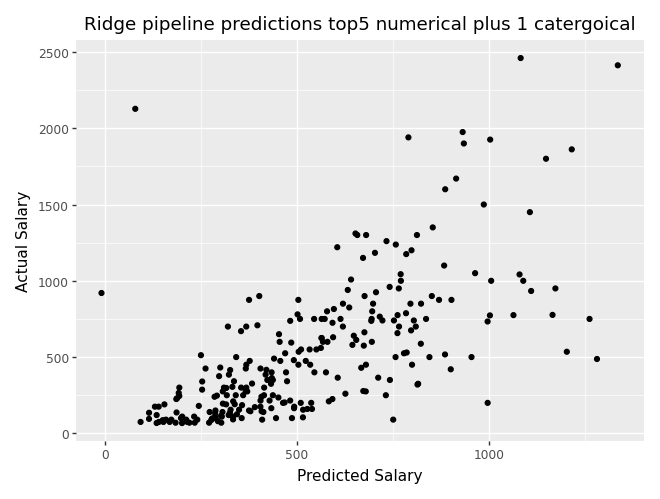

In [242]:
(p9.ggplot(p9.aes(y= y_A, x = y_pred))
+p9.geom_point()
+p9.labs(title="Ridge pipeline predictions top5 numerical plus 1 catergoical",
    x= "Predicted Salary", y = "Actual Salary")
)

Overall this model doesnt predict the Salary perfectly but given acurate coefficents you can get a good estimate to a players salary based on the categorical variables provided. With more tuning to this model i believe it could have lots of signifcance and the MSE can be lowered with serveral adjustment and added methods. Based in the plot we can see that our model underestimates salary which but their are several points that are close enough to the original salary variable that we can see the significance of the model overall and why it was choosen over the other models we worked with throughout this lab. 